In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import hdbscan as HD
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tuning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tuning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
dict_embedding = {}
dict_embedding["WMD"] = dict_wmd_embedding
dict_embedding["Moyenne"] = dict_moy_embedding

In [18]:
df_hdbscan_clustering = pd.read_csv("data/tuning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering["clustering"] = "hdbscan"
df_hdbscan_clustering["K"]  = df_hdbscan_clustering["K"] - 1
df_kmeans_clustering = pd.read_csv("data/tuning/clustering/kmeans.csv",sep=";")
df_gmm_clustering = pd.read_csv("data/tuning/clustering/gmm.csv",sep=";")
df_gmm_clustering["clustering"] = "gmm"
df_clustering = pd.concat([df_hdbscan_clustering,df_kmeans_clustering,df_gmm_clustering])
df_clustering = df_clustering[df_clustering["K"]>=5]
df_clustering = df_clustering[df_clustering["K"]<=20]
df_clustering.head()

voisinage  min_cluster_size     distance  K  silhouette  Cal-Harabasz  \
41       20.0              11.0  precomputed  5    0.321917           NaN   
42       20.0              12.0  precomputed  5    0.321917           NaN   
51       19.0              10.0  precomputed  5    0.315283           NaN   
60       10.0              10.0  precomputed  5    0.340517           NaN   
81       42.0              10.0  precomputed  5    0.303762           NaN   

        DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
41  0.119809        671.0         NaN          cbow          WMD   
42  0.119809        671.0         NaN          cbow          WMD   
51  0.114788        680.0         NaN          cbow          WMD   
60  0.108204        580.0         NaN          cbow          WMD   
81  0.089011        695.0         NaN          cbow          WMD   

   docEmbedding2 clustering initialisation  nb_iter  tolerance  val_obj  \
41      Distance    hdbscan            NaN      NaN        NaN      NaN   
42      Distance    hdbscan            NaN      NaN        NaN      NaN   
51      Distance    hdbscan            NaN      NaN        NaN      NaN   
60      Distance    hdbscan            NaN      NaN        NaN      NaN   
81      Distance    hdbscan            NaN      NaN        NaN      NaN   

   covariance  BIC  
41        NaN  NaN  
42        NaN  NaN  
51        NaN  NaN  
60        NaN  NaN  
81        NaN  NaN

# Clustering Avant Tsne

In [19]:
df_clustering_before = df_clustering.loc[(df_clustering["perplexity"].isna())].reset_index()

In [20]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance   K  silhouette  \
0       41       20.0              11.0  precomputed   5    0.321917   
67   10714        3.0              11.0    euclidean  11   -0.143543   
179  53569       38.0              10.0  precomputed   6    0.187349   

     Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
0             NaN  0.119809        671.0         NaN          cbow   
67      12.868416  0.003273       9215.0         NaN         glove   
179           NaN  0.278496        481.0         NaN      skipgram   

    docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
0            WMD      Distance    hdbscan            NaN      NaN        NaN   
67       Moyenne            TF    hdbscan            NaN      NaN        NaN   
179          WMD      Distance    hdbscan            NaN      NaN        NaN   

     val_obj covariance  BIC  
0        NaN        NaN  NaN  
67       NaN        NaN  NaN  
179      NaN        NaN  NaN

In [21]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size   distance  K  silhouette  \
253    187        NaN               NaN        NaN  5    0.405681   
702   1810        NaN               NaN        NaN  5    0.160676   
99   22141        6.0              10.0  euclidean  5    0.481659   

     Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
253  15337.873936 -0.749637          NaN         NaN          cbow   
702     48.114086 -0.616269          NaN         NaN         glove   
99     489.760064 -0.248700        579.0         NaN      skipgram   

    docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
253      Moyenne         TFIDF     kmeans      k-means++     10.0     0.0001   
702      Moyenne         TFIDF        gmm            NaN      NaN        NaN   
99       Moyenne         TFIDF    hdbscan            NaN      NaN        NaN   

        val_obj covariance           BIC  
253  396.268091        NaN           NaN  
702         NaN       full -3.130738e+07  
99          NaN        NaN           NaN

In [22]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  Cal-Harabasz  \
252    186        NaN               NaN      NaN  5    0.405154  15339.302799   
312    578        NaN               NaN      NaN  5    0.035087    145.752720   
352    940        NaN               NaN      NaN  5    0.291723   5690.425304   

         DBCV  non_classes  perplexity wordEmbedding docEmbedding  \
252 -0.753192          NaN         NaN          cbow      Moyenne   
312 -0.697669          NaN         NaN         glove      Moyenne   
352 -0.805468          NaN         NaN      skipgram      Moyenne   

    docEmbedding2 clustering initialisation  nb_iter  tolerance     val_obj  \
252         TFIDF     kmeans         random     10.0     0.0001  396.232829   
312            TF     kmeans      k-means++     10.0     0.0001    0.417098   
352         TFIDF     kmeans         random     10.0     0.0001  604.194378   

    covariance  BIC  
252        NaN  NaN  
312        NaN  NaN  
352        NaN  NaN

# Clustering Apres Tsne

In [23]:
df_clustering_after = df_clustering.loc[(df_clustering["perplexity"].notna())].reset_index()

In [24]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance   K  silhouette  \
431    2295      200.0             100.0  euclidean   5   -0.269958   
2531  14536      150.0              10.0  euclidean  11   -0.298547   
8982  49886       48.0             100.0  euclidean  19   -0.162440   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
431     753.185680  0.147703       5828.0       100.0          cbow   
2531    276.077154  0.116965       5841.0       150.0         glove   
8982    632.930565  0.115563       4671.0        75.0      skipgram   

     docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
431           WMD      Distance    hdbscan            NaN      NaN        NaN   
2531      Moyenne            TF    hdbscan            NaN      NaN        NaN   
8982      Moyenne            TF    hdbscan            NaN      NaN        NaN   

      val_obj covariance  BIC  
431       NaN        NaN  NaN  
2531      NaN        NaN  NaN  
8982      NaN        NaN  NaN

In [25]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  \
11176    356        NaN               NaN      NaN  5    0.493015   
12214   2018        NaN               NaN      NaN  6    0.383739   
11451    819        NaN               NaN      NaN  8    0.412623   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
11176  20271.669489 -0.659591          NaN       200.0          cbow   
12214   8468.996606 -0.825968          NaN       125.0         glove   
11451  11656.610215 -0.708491          NaN        75.0      skipgram   

      docEmbedding docEmbedding2 clustering initialisation  nb_iter  \
11176      Moyenne         TFIDF     kmeans         random     10.0   
12214          WMD      Distance     kmeans      k-means++     10.0   
11451          WMD           MDS     kmeans         random     10.0   

       tolerance       val_obj covariance  BIC  
11176     0.0001  9.235383e+05        NaN  NaN  
12214     0.0001  2.185364e+06        NaN  NaN  
11451     0.0001  8.768532e+05        NaN  NaN

In [26]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance   K  silhouette  \
11158    338        NaN               NaN      NaN  14    0.404300   
12138   1924        NaN               NaN      NaN  10    0.373191   
11638   1092        NaN               NaN      NaN  14    0.383962   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
11158  24527.133503 -0.618270          NaN       200.0          cbow   
12138   8995.073630 -0.757997          NaN        50.0         glove   
11638  14189.799335 -0.630786          NaN       200.0      skipgram   

      docEmbedding docEmbedding2 clustering initialisation  nb_iter  \
11158      Moyenne         TFIDF     kmeans      k-means++     10.0   
12138          WMD      Distance     kmeans         random     10.0   
11638      Moyenne         TFIDF     kmeans         random     10.0   

       tolerance       val_obj covariance  BIC  
11158     0.0001  2.545374e+05        NaN  NaN  
12138     0.0001  3.064856e+06        NaN  NaN  
11638     0.0001  3.457451e+05        NaN  NaN

# Plot ScatterPlot

In [27]:
def plot_best(df_clustering,dict_embedding,clustering_metric="silhouette",modele="cbow"):
    best_model = df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmin()] if clustering_metric == "BIC" else df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"
        first_reduce = best_model["perplexity"].notna().values[0]

        doc_embedding = dict_embedding[best_model["docEmbedding"].values[0]][modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)
        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])
        clustering_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]

        type_clustering = best_model["clustering"].values[0].upper()

        if type_clustering == "HDBSCAN":
            clust_model = HD.HDBSCAN(min_cluster_size=int(best_model["min_cluster_size"].values[0]), metric = best_model["distance"].values[0],min_samples=int(best_model["voisinage"].values[0]))
        elif type_clustering == "GMM":
            clust_model = GMM(n_components=best_model["K"].values[0],covariance_type=best_model["covariance"].values[0])
        elif type_clustering == "KMEANS":
            clust_model = KMeans(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0])
        elif type_clustering == "KMEDOIDES":
            clust_model = KMedoids(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0], metric = 'precomputed')

        labels = clust_model.fit_predict(np.array(clustering_data).astype(np.float64))

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best DocEmbedding Clustering based on {clustering_metric} metric from {type_clustering} algorithm"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reducing Before Clustering: {first_reduce}" 
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - Silhouette: {round(best_model['silhouette'].values[0],2)} - DBCV: {round(best_model['DBCV'].values[0],2)} - Calinski-Harabasz: {round(best_model['Cal-Harabasz'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

############################################################################################################################
                                                  SKIPGRAM                                                                         
############################################################################################################################


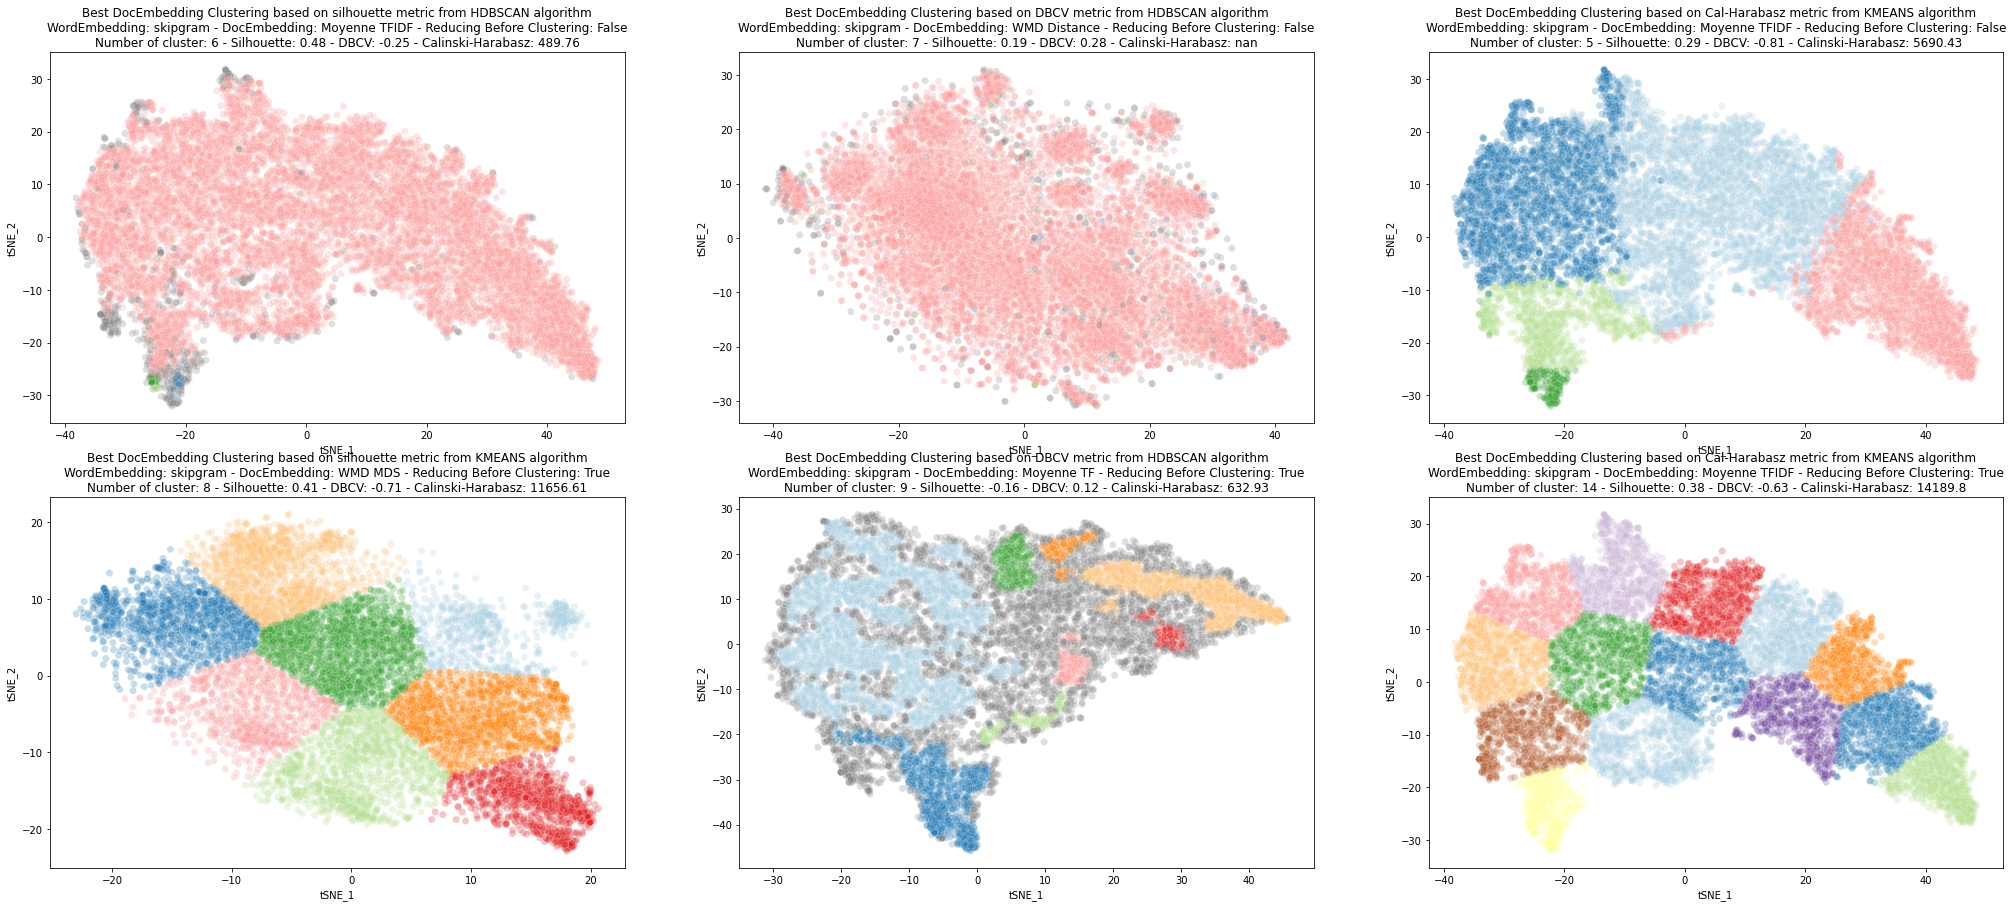

############################################################################################################################
                                                  GLOVE                                                                         
############################################################################################################################


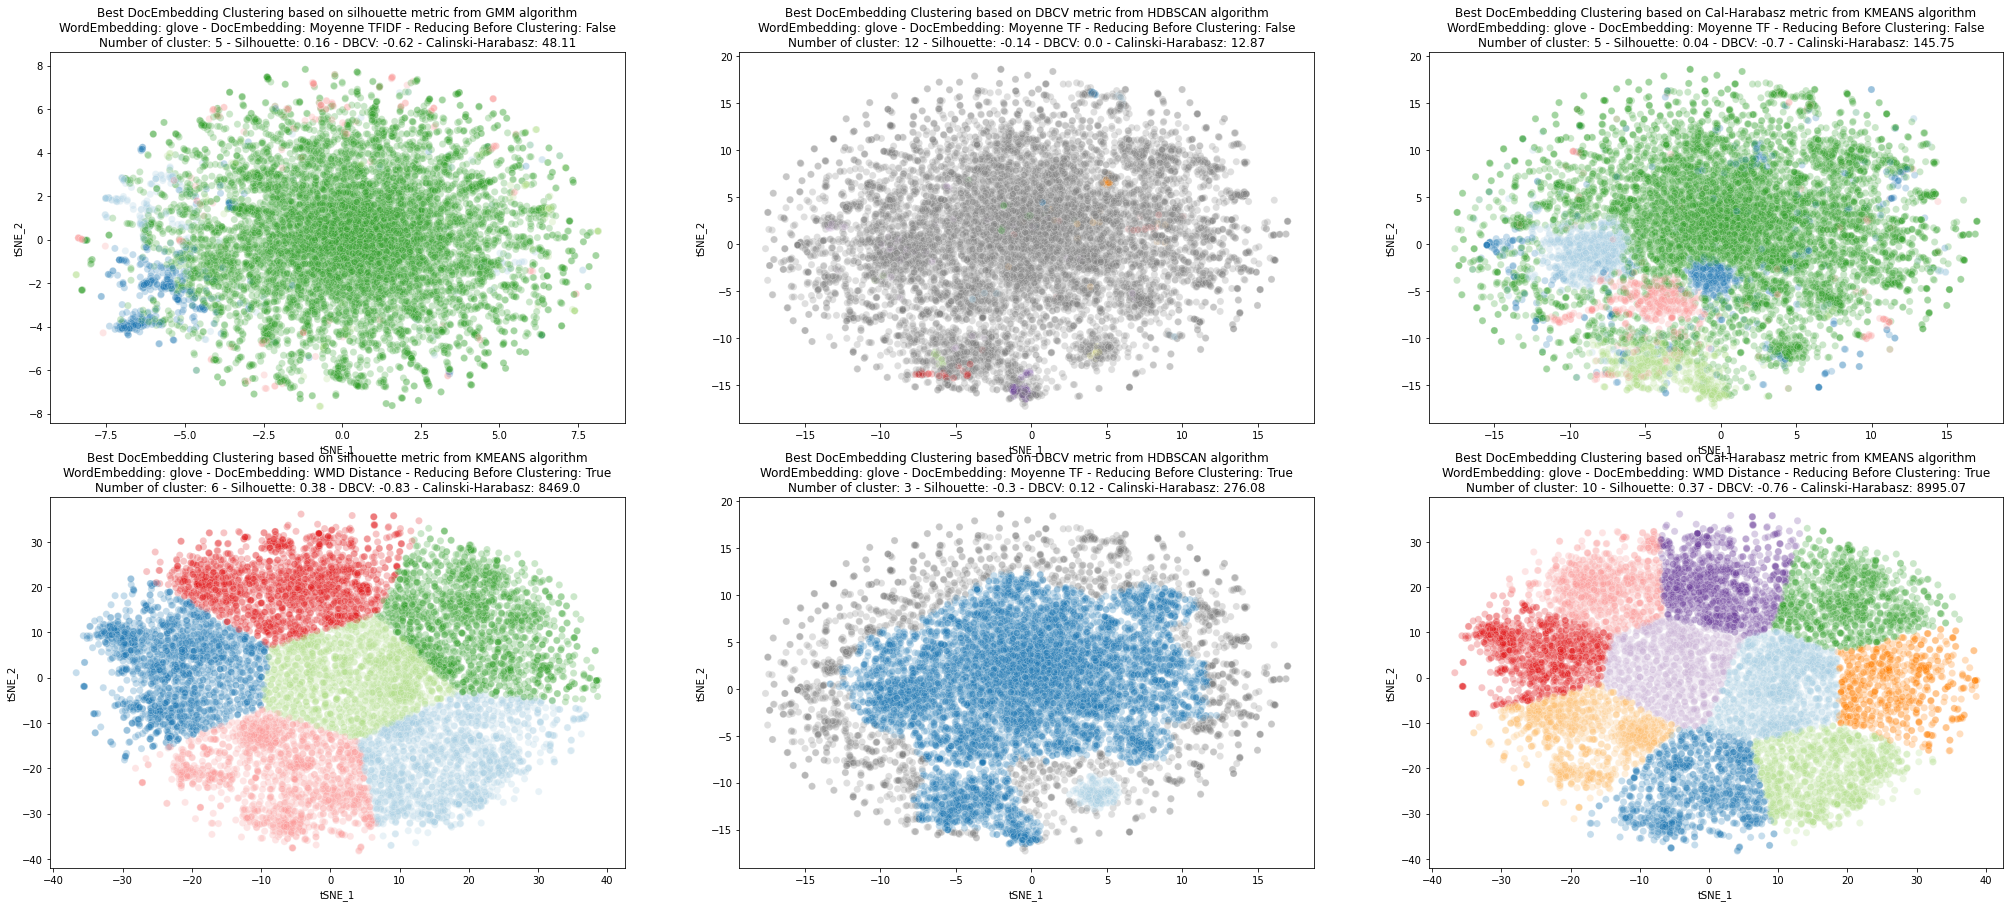

############################################################################################################################
                                                  CBOW                                                                         
############################################################################################################################


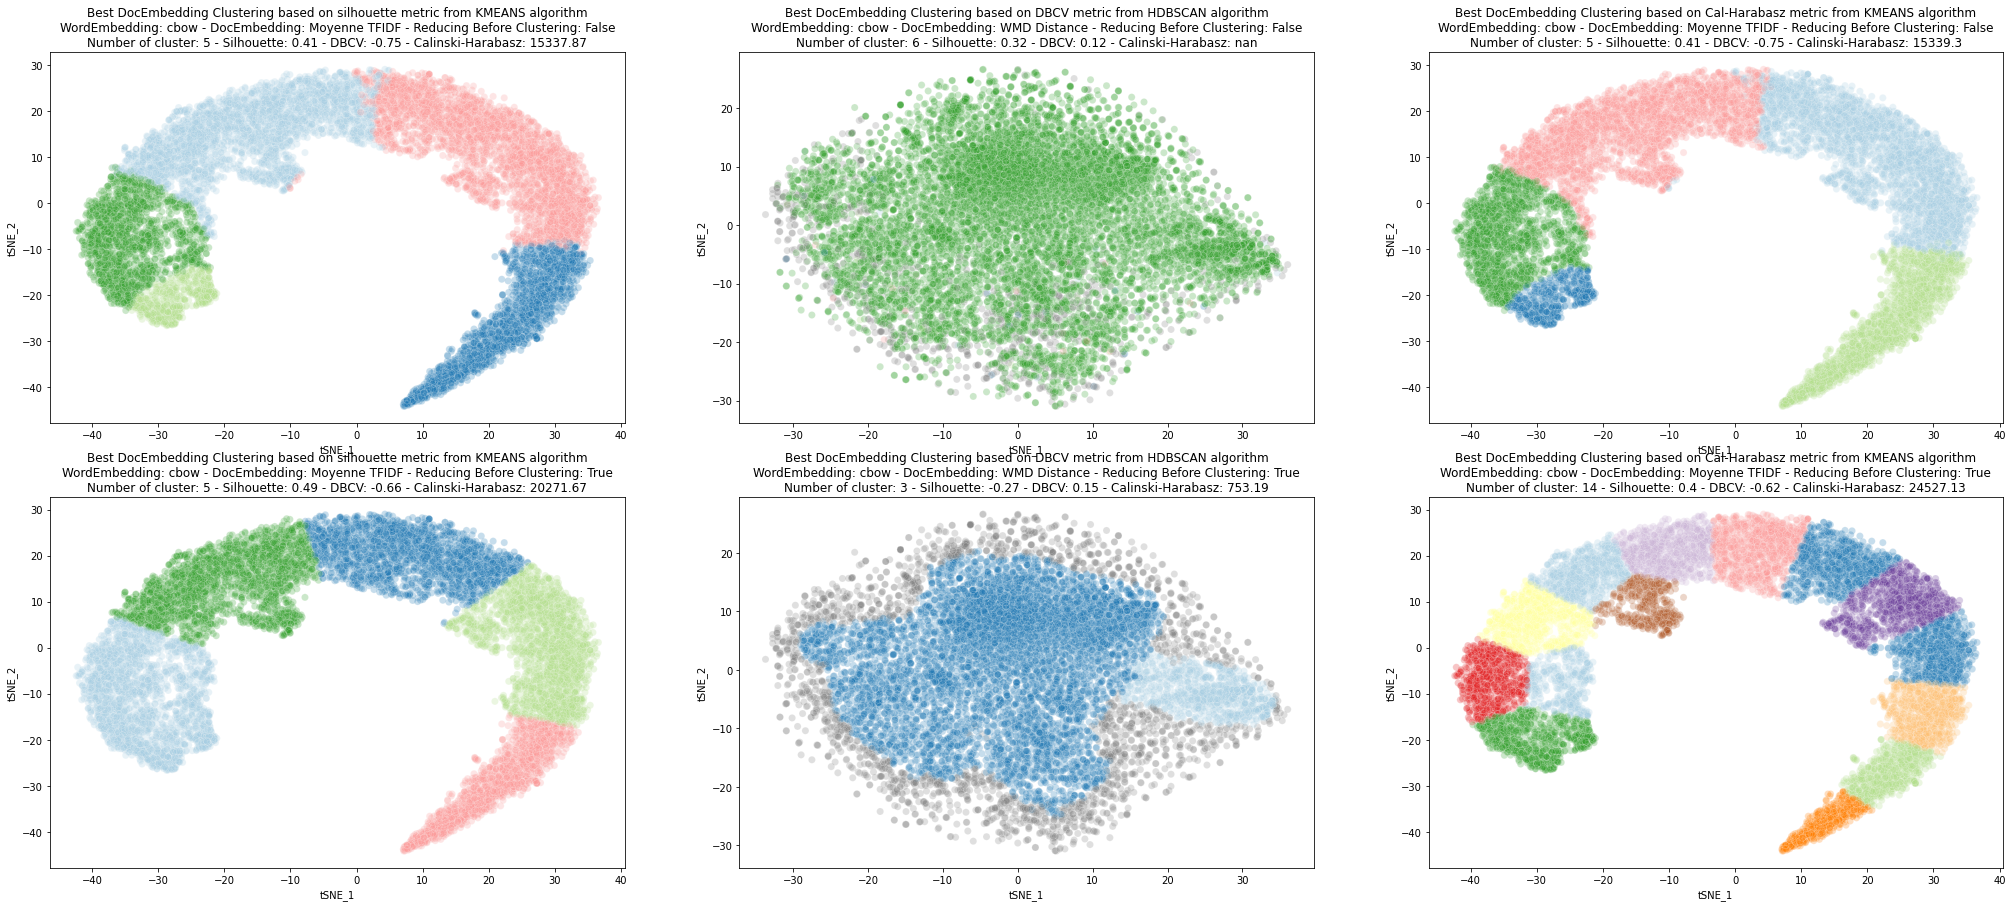

TypeError: a bytes-like object is required, not 'str'

In [28]:
dict_label = {"ReductionFirst":{},"ReductionAfter":{}}
for modele in ["skipgram","glove","cbow"]:
    print("############################################################################################################################")
    print(f"                                                  {modele.upper()}                                                                         ")
    print("############################################################################################################################")
    dict_label["ReductionFirst"][modele] = {}
    dict_label["ReductionAfter"][modele] = {}
    #Silhouette
    labels_silhouette, tsne_silhouette, silhouette_colors, silhouette_title = plot_best(df_clustering_before,dict_embedding,clustering_metric="silhouette",modele=modele)
    labels_silhouette2, tsne_silhouette2, silhouette_colors2, silhouette_title2 = plot_best(df_clustering_after,dict_embedding,clustering_metric="silhouette",modele=modele)
    dict_label["ReductionFirst"][modele]["silhouette"] = labels_silhouette2
    dict_label["ReductionAfter"][modele]["silhouette"] = labels_silhouette
    #DBCV
    labels_dbcv, tsne_dbcv, dbcv_colors, dbcv_title = plot_best(df_clustering_before,dict_embedding,clustering_metric="DBCV",modele=modele)
    labels_dbcv2, tsne_dbcv2, dbcv_colors2, dbcv_title2 = plot_best(df_clustering_after,dict_embedding,clustering_metric="DBCV",modele=modele)
    dict_label["ReductionFirst"][modele]["dbcv"] = labels_dbcv2
    dict_label["ReductionAfter"][modele]["dbcv"] = labels_dbcv
    #Cal
    labels_cal, tsne_cal, cal_colors, cal_title = plot_best(df_clustering_before,dict_embedding,clustering_metric="Cal-Harabasz",modele=modele)
    labels_cal2, tsne_cal2, cal_colors2, cal_title2 = plot_best(df_clustering_after,dict_embedding,clustering_metric="Cal-Harabasz",modele=modele)
    dict_label["ReductionFirst"][modele]["Cal-Harabasz"] = labels_cal2
    dict_label["ReductionAfter"][modele]["Cal-Harabasz"] = labels_cal
    
    #Plot
    plt.figure(figsize = (35,15))

    sns.scatterplot(tsne_silhouette[:,0],tsne_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(2,3,1,title=silhouette_title,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_dbcv[:,0],tsne_dbcv[:,1], s=50, c=dbcv_colors, alpha=0.25,ax=plt.subplot(2,3,2,title=dbcv_title,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_cal[:,0],tsne_cal[:,1], s=50, c=cal_colors, alpha=0.25,ax=plt.subplot(2,3,3,title=cal_title,xlabel="tSNE_1",ylabel="tSNE_2"))

    sns.scatterplot(tsne_silhouette2[:,0],tsne_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(2,3,4,title=silhouette_title2,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_dbcv2[:,0],tsne_dbcv2[:,1], s=50, c=dbcv_colors2, alpha=0.25,ax=plt.subplot(2,3,5,title=dbcv_title2,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_cal2[:,0],tsne_cal2[:,1], s=50, c=cal_colors2, alpha=0.25,ax=plt.subplot(2,3,6,title=cal_title2,xlabel="tSNE_1",ylabel="tSNE_2"))
    
    plt.show()

In [40]:
dict_label_copy = dict_label.copy()
for key1 in dict_label_copy.keys():
    for key2 in dict_label_copy[key1].keys():
        for key3 in dict_label_copy[key1][key2].keys():
            dict_label_copy[key1][key2][key3] = list(dict_label_copy[key1][key2][key3])

9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501


In [44]:
def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError

with open("data/tuning/clustering/best_labels.json", "w") as output_file:
    json.dump(dict_label_copy,output_file,default=convert)

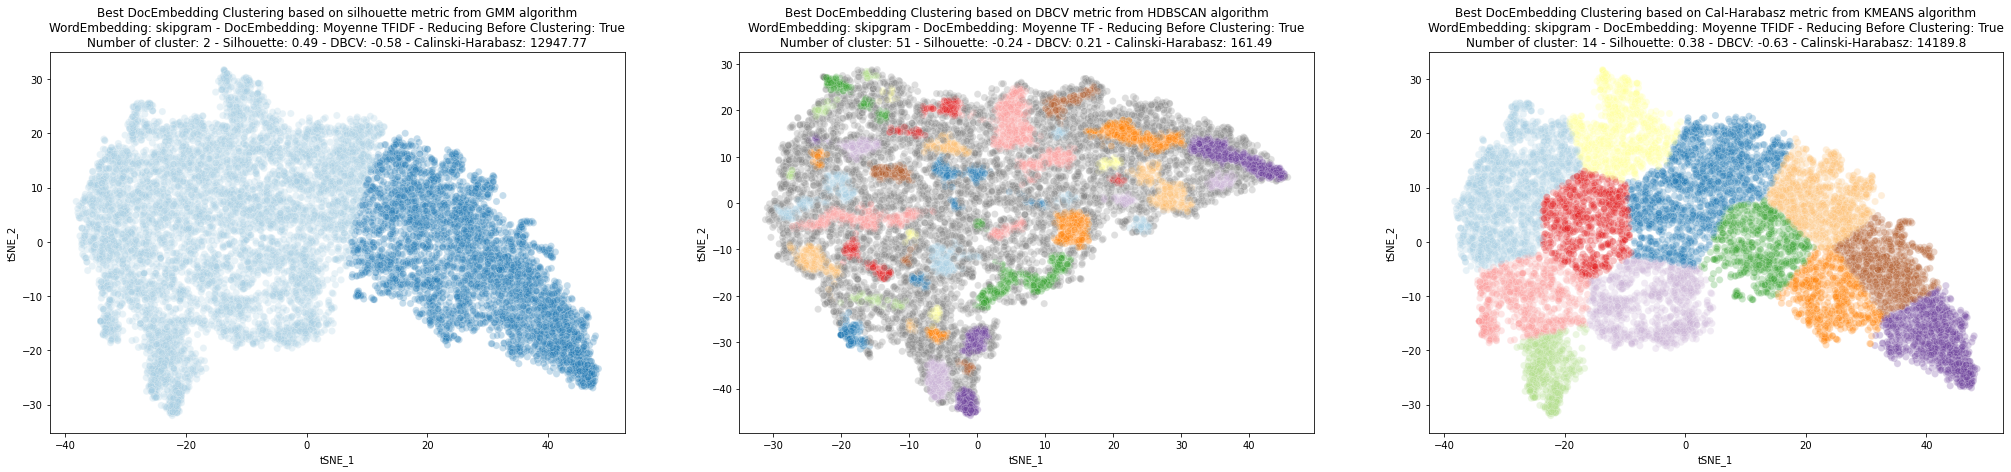

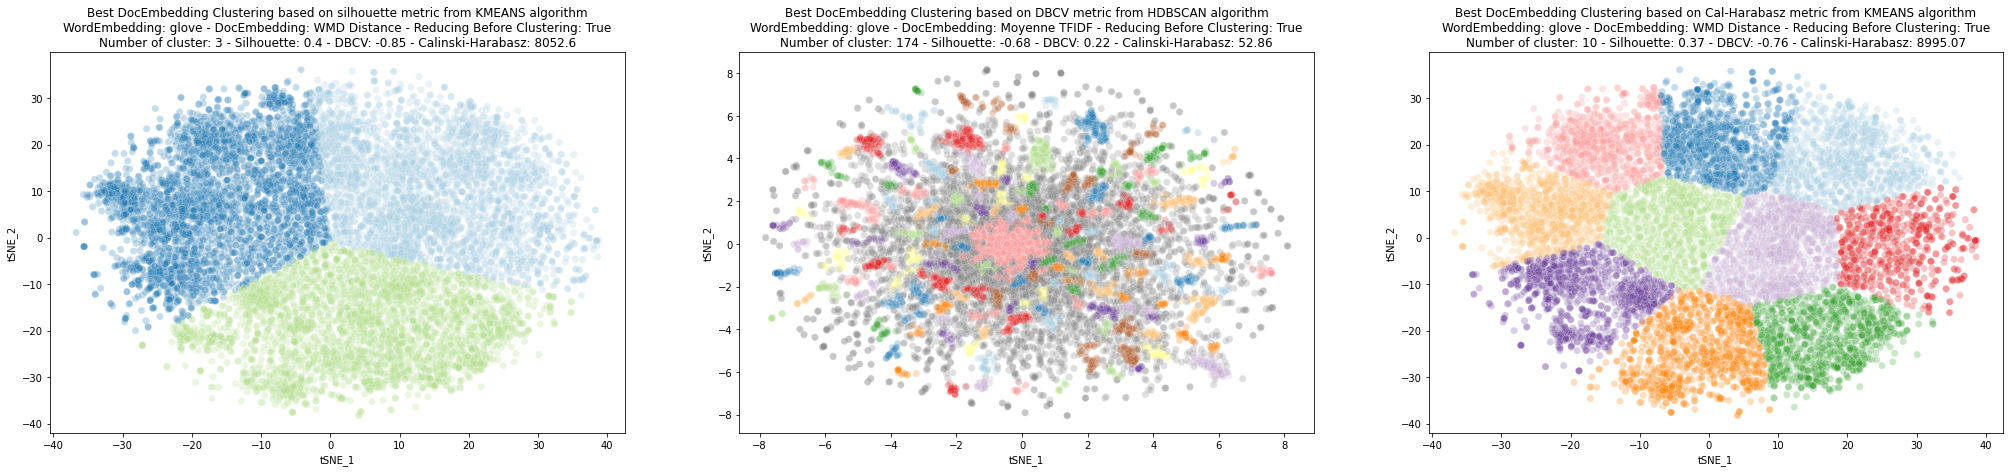

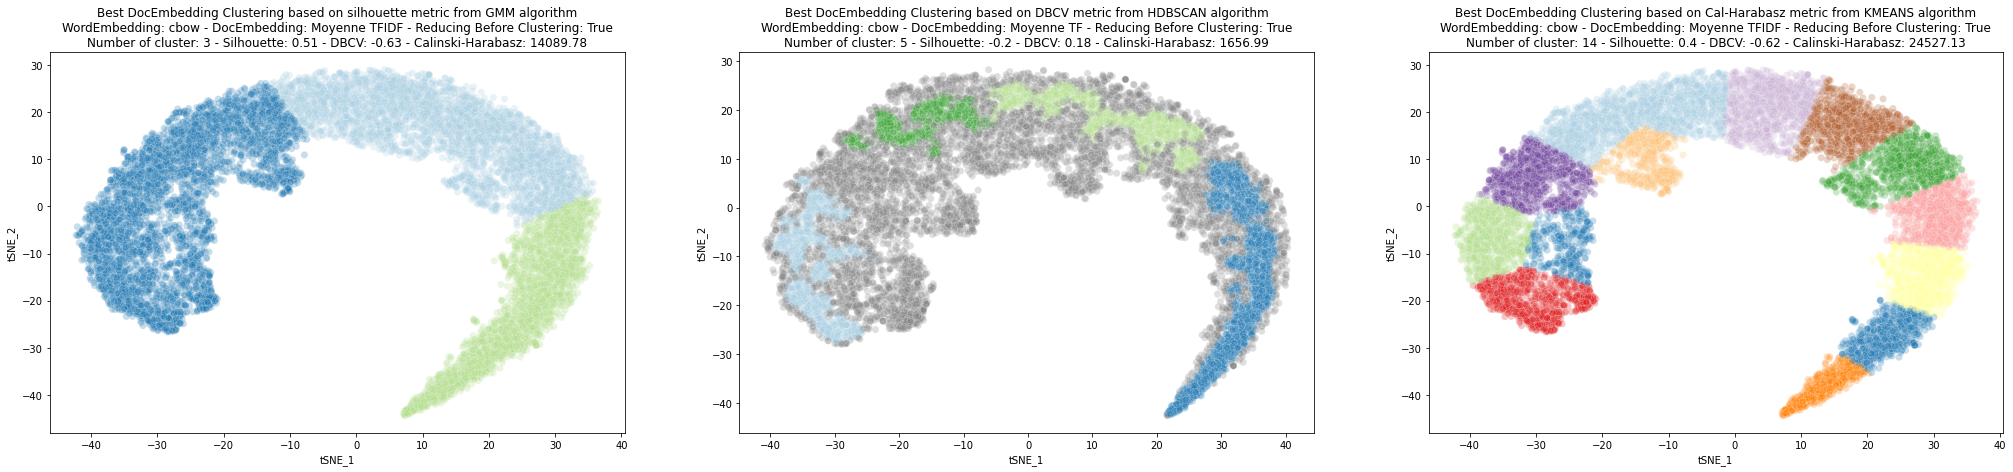

In [ ]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_silhouette, silhouette_colors, silhouette_title = plot_best(df_clustering_after,dict_embedding,clustering_metric="silhouette",modele=modele)
    #DBCV
    labels_dbcv, tsne_dbcv, dbcv_colors, dbcv_title = plot_best(df_clustering_after,dict_embedding,clustering_metric="DBCV",modele=modele)
    #Cal
    labels_cal, tsne_cal, cal_colors, cal_title = plot_best(df_clustering_after,dict_embedding,clustering_metric="Cal-Harabasz",modele=modele)

    #Plot
    plt.figure(figsize = (35,7))

    sns.scatterplot(tsne_silhouette[:,0],tsne_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,3,1,title=silhouette_title,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_dbcv[:,0],tsne_dbcv[:,1], s=50, c=dbcv_colors, alpha=0.25,ax=plt.subplot(1,3,2,title=dbcv_title,xlabel="tSNE_1",ylabel="tSNE_2"))
    sns.scatterplot(tsne_cal[:,0],tsne_cal[:,1], s=50, c=cal_colors, alpha=0.25,ax=plt.subplot(1,3,3,title=cal_title,xlabel="tSNE_1",ylabel="tSNE_2"))
    
    plt.show()